In [1]:
#!/usr/bin/env python3
import numpy as np
import os
from scipy.stats import pearsonr, ks_2samp


"""
Example script that:
    1) Loads FC_grid and FCD_grid from .npy files
    2) Loads emp_FC and emp_FCD from .npy (or .mat) files
    3) Computes (1 - corr(FC, emp_FC)) for each [i_lr, i_g]
    4) Computes KS distance between FCD distributions and emp_FCD
"""

# -------------------------------------------------------------------------
# 1) Load FC_grid, FCD_grid
# -------------------------------------------------------------------------
# Adjust the paths to your own structure
results_path = "/network/iss/cohen/data/Ivan/dyn_fic_dmf_simulations/Results/FC_FCD_Grid"
FC_grid_file = os.path.join(results_path, "FC_grid.npy")
FCD_grid_file = os.path.join(results_path, "FCD_grid.npy")

print("Loading FC_grid...")
FC_grid = np.load(FC_grid_file)  
print("Loading FCD_grid...")
FCD_grid = np.load(FCD_grid_file)

Loading FC_grid...
Loading FCD_grid...


In [22]:
import fastdyn_fic_dmf as dmf
from scipy.io import loadmat
import mat73

def compute_fcd(data, wsize, overlap, isubdiag, params):
    T, N = data.shape
    win_start = np.arange(0, T - params["wsize"] - 1, params["wsize"] - overlap)
    nwins = len(win_start)
    fcd = np.zeros((len(isubdiag[0]), nwins))
    for i in range(nwins):
        tmp = data[win_start[i]:win_start[i] + params["wsize"] + 1, :]
        cormat = np.corrcoef(tmp.T)
        fcd[:, i] = cormat[isubdiag[0], isubdiag[1]]
    return fcd

C = loadmat('./data/DTI_fiber_consensus_HCP.mat')['connectivity'][:200, :200]
C = 0.2 * C / np.max(C)
params = dmf.default_params(C=C)
params['N'] = C.shape[0]
isubfcd = np.triu_indices(C.shape[1], 1)
burnout = 7
params["wsize"] = 30
overlap = 29
params['TR'] = 2
T = 250
params['dtt'] = 0.001  # Assuming 'dtt' is defined; adjust as needed
nb_steps = int(T * params['TR'] / params['dtt'])
win_start = np.arange(0, T - burnout - params["wsize"], params["wsize"] - overlap)
nwins = len(win_start)
nints = len(isubfcd[0])

emp_data = mat73.loadmat('data/BOLD_timeseries_Awake.mat')
emp_data = np.squeeze(np.array(emp_data['BOLD_timeseries_Awake']))[:,:200,:]
emp_data = emp_data[:,:,burnout:]


emp_fcds = []
for sub in range(emp_data.shape[0]):
    fcds = compute_fcd(emp_data[sub, :, :].T, params["wsize"], overlap, isubfcd, params)
    upp_tr_fcd = np.corrcoef(fcds.T)[np.triu_indices(nwins-1, 1)]
    emp_fcds.append(upp_tr_fcd)

emp_FC = np.mean(np.array([np.corrcoef(emp_data[sub, :, :]) for sub in range(emp_data.shape[0])]), axis=0)
emp_FCD = np.hstack((emp_fcds))


In [26]:

# Let's define the indices for the upper triangle (excluding diagonal):
N = emp_FC.shape[0]
i_triu = np.triu_indices(N, k=1)

# Flatten the empirical FC's upper-triangular part
emp_FC_ut = emp_FC[i_triu].flatten()

# For empirical FCD, we might flatten the entire [num_windows x num_windows]
# or only upper triangle as well. Adjust to your usage.

# If you store it as a matrix, you can flatten upper-tri as well:
i_triu_fcd = np.triu_indices(nwins-1, k=1)
emp_FCD_ut = emp_FCD

# -------------------------------------------------------------------------
# 3) Pre-allocate results for the grid
# -------------------------------------------------------------------------
nLR = FC_grid.shape[0]
nG  = FC_grid.shape[1]

# We'll store (1 - corr) in an array of shape (nLR, nG)
dist_fc_grid = np.zeros((nLR, nG), dtype=np.float32)

# We'll store KS distance in an array of shape (nLR, nG)
ks_fcd_grid = np.zeros((nLR, nG), dtype=np.float32)

# -------------------------------------------------------------------------
# 4) Loop over each [i_lr, i_g] and compute distances
# -------------------------------------------------------------------------
for i_lr in range(nLR):
    for i_g in range(nG):
        # ~~~~~ FC ~~~~~
        sim_FC = FC_grid[i_lr, i_g]     # shape (N, N)
        sim_FC_ut = sim_FC[i_triu].flatten()

        # Compute correlation of upper-tri vector vs. empirical
        if np.isnan(sim_FC_ut).any() or np.all(sim_FC_ut == 0):
            dist_fc_grid[i_lr, i_g] = 1.0
        else:
            r, _ = pearsonr(sim_FC_ut, emp_FC_ut)
            dist_fc_grid[i_lr, i_g] = 1.0 - r

        # ~~~~~ FCD ~~~~~
        # FCD_grid[i_lr, i_g] has shape (n_seeds, num_windows, num_windows)
        # We can flatten across seeds or do something else. For example:
        #  1) Flatten each seed's [num_windows x num_windows] -> 1D
        #  2) Concatenate them all seeds => single 1D distribution
        # Then compute KS distance vs. empirical

        fcd_seeds = FCD_grid[i_lr, i_g]  
        # shape = (n_seeds, num_windows, num_windows)

        # Flatten each seed in the same upper-tri manner, then concat
        all_fcd_vals = []
        for seed_idx in range(fcd_seeds.shape[0]):
            # shape (num_windows, num_windows)
            fcd_mat = fcd_seeds[seed_idx]
            if np.isnan(fcd_mat).any() or np.all(fcd_mat == 0):
                fcd_ut = np.ones(i_triu_fcd[0].shape)
            else:
                fcd_ut = fcd_mat[i_triu_fcd].flatten()
            all_fcd_vals.append(fcd_ut)
        # Now create one big 1D array of FCD values
        all_fcd_vals = np.concatenate(all_fcd_vals, axis=0)

        # Finally, compare with empirical FCD distribution using KS
        # NOTE: ks_2samp expects two 1D arrays
        ks_stat, _ = ks_2samp(all_fcd_vals, emp_FCD_ut)
        ks_fcd_grid[i_lr, i_g] = ks_stat
        ks_fcd_grid[i_lr, i_g] = ks_stat

    print(f"Done i_lr={i_lr+1}/{nLR}")

Done i_lr=1/110
Done i_lr=2/110
Done i_lr=3/110
Done i_lr=4/110
Done i_lr=5/110
Done i_lr=6/110
Done i_lr=7/110
Done i_lr=8/110
Done i_lr=9/110
Done i_lr=10/110
Done i_lr=11/110
Done i_lr=12/110
Done i_lr=13/110
Done i_lr=14/110
Done i_lr=15/110
Done i_lr=16/110
Done i_lr=17/110
Done i_lr=18/110
Done i_lr=19/110
Done i_lr=20/110
Done i_lr=21/110
Done i_lr=22/110
Done i_lr=23/110
Done i_lr=24/110
Done i_lr=25/110
Done i_lr=26/110
Done i_lr=27/110
Done i_lr=28/110
Done i_lr=29/110
Done i_lr=30/110
Done i_lr=31/110
Done i_lr=32/110
Done i_lr=33/110
Done i_lr=34/110
Done i_lr=35/110
Done i_lr=36/110
Done i_lr=37/110
Done i_lr=38/110
Done i_lr=39/110
Done i_lr=40/110
Done i_lr=41/110
Done i_lr=42/110
Done i_lr=43/110
Done i_lr=44/110
Done i_lr=45/110
Done i_lr=46/110
Done i_lr=47/110
Done i_lr=48/110
Done i_lr=49/110
Done i_lr=50/110
Done i_lr=51/110
Done i_lr=52/110
Done i_lr=53/110
Done i_lr=54/110
Done i_lr=55/110
Done i_lr=56/110
Done i_lr=57/110
Done i_lr=58/110
Done i_lr=59/110
Done i

In [32]:
dist_fc_grid

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]], dtype=float32)

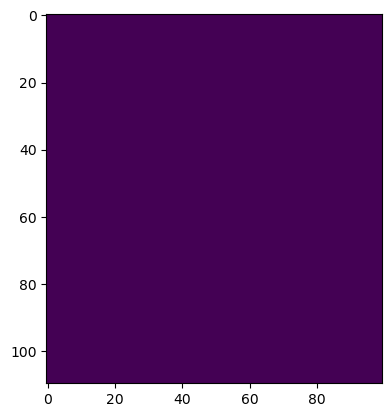

In [31]:
import matplotlib.pyplot as plt
plt.imshow(dist_fc_grid)

In [27]:
import seaborn as sns
sns.heatmap(dist_fc_grid, annot=True, fmt=".3f")

<Axes: >

Error in callback <function flush_figures at 0x7f5da6345d80> (for post_execute):


KeyboardInterrupt: 

In [ ]:



# -------------------------------------------------------------------------
# 5) Save or do something with dist_fc_grid and ks_fcd_grid
# -------------------------------------------------------------------------
# For example:
np.save("dist_fc_grid.npy", dist_fc_grid)
np.save("ks_fcd_grid.npy", ks_fcd_grid)
print("[main] Done. Saved dist_fc_grid.npy and ks_fcd_grid.npy.")



In [9]:
#!/usr/bin/env python3
import sys
import os
import argparse
import math
import time
import numpy as np
from scipy.io import loadmat
from multiprocessing import Pool

# Custom modules (as in your snippet)
import fastdyn_fic_dmf as dmf
from helper_functions import filter_bold

################################################################################
# Helper functions
################################################################################

def compute_fc(data):
    """
    Compute FC by correlating BOLD (or rate) time series.
    data shape: (time, nodes).
    Returns an (N x N) correlation matrix.
    """
    return np.corrcoef(data.T)  # shape [N, N]

def compute_fcd(data, wsize, overlap, isubdiag):
    """
    Compute FCD by sliding a window of length 'wsize' with 'overlap' into 'data'.
    
    data shape: (time, nodes).
    wsize, overlap: integer time points.
    isubdiag: np.triu_indices(N, 1) or similar.

    Returns a 2D array:
        shape [num_windows, number_of_corr_pairs]
    where number_of_corr_pairs = len(isubdiag[0]).
    """
    T, N = data.shape
    step = wsize - overlap
    win_starts = np.arange(0, T - wsize + 1, step)
    
    fcd_mat = []
    for start in win_starts:
        window_data = data[start:start + wsize, :]
        cormat = np.corrcoef(window_data.T)
        fcd_mat.append(cormat[isubdiag])
    fcd_mat = np.corrcoef(np.array(fcd_mat))  # shape [num_windows, n_subdiag]
    return fcd_mat  # shape [num_windows, n_subdiag]



def simulate_one_seed(args):
    """
    Run the DMF model for a single seed, given LR and G (plus a,b for DECAY),
    and return (FC, FCD).
    """
    (params_base, nb_steps, burnout, wsize, overlap, seed_id, a, b, isubdiag) = args

    # Copy base params so we don't mutate them
    params = params_base.copy()
    params['seed'] = seed_id
    
    # Compute DECAY from a, b, lrj
    DECAY = np.exp(a + np.log(params['lrj']) * b)
    params['taoj'] = DECAY
    
    # Because we want to see plastic changes
    params["with_plasticity"] = True
    params["with_decay"]      = True
    
    # (Re)compute 'J' after setting alpha, G, etc.
    # If alpha is always 0.75 or you prefer a different logic, do it here:
    params['alpha'] = 0.75
    params['J'] = params['alpha'] * params['G'] * params['C'].sum(axis=0).squeeze() + 1

    # Run DMF
    # Returns: (rates, bold, fic, etc.) -- adjust if your function differs
    try:
        _, _, bold, _ = dmf.run(params, nb_steps)
        
        # Take out the nan values
        bold[np.isnan(bold)] = 0
        # Burn out the initial transients
        bold_post = bold[:, burnout:]  # shape [N, T-burnout]
        # If we need to filter the BOLD, do it here
        # Convert to shape [time, nodes] for correlation
        bold_post = bold_post.T  # shape [T-burnout, N]
        bold_filt = filter_bold(bold_post, params['flp'], params['fhp'], params['TR'])

        # Compute FC
        fc_seed = compute_fc(bold_filt)  # shape [N, N]

        # Compute FCD
        fcd_seed = compute_fcd(bold_filt, wsize, overlap, isubdiag)  
    except:
        print(f"Error in seed {seed_id}, returning zeros.")
        print(f"G={params['G']}, LR={params['lrj']}")
        fc_seed = np.zeros((params['N'], params['N']), dtype=np.float32)
        fcd_seed = np.zeros((1, 1), dtype=np.float32)
    # shape [num_windows, n_subdiag]

    return fc_seed, fcd_seed

def grid_step(args):
    """
    Process a single (LR, G) pair by running multiple seeds.
    Return:
      {
        'idx_lr': idx_lr,
        'idx_g':  idx_g,
        'FC_avg':  (N x N),
        'FCD_stacked': (n_seeds x num_windows x n_subdiag)
      }
    """
    (idx_lr, LR_val, idx_g, G_val,
     params, nb_steps, burnout, wsize, overlap, n_seeds,
     a, b, isubdiag) = args

    # Set the LR & G in the param dictionary
    params['lrj'] = LR_val
    params['G']   = G_val
    
    N = params['N']

    # We'll sum FCs to get an average later
    fc_sum = np.zeros((N, N), dtype=np.float32)
    fcd_list = []

    # Prepare a local list of seeds
    # Example: we might do seeds = range(n_seeds), or something more elaborate
    # For demonstration, we just do seeds 0..(n_seeds-1)
    seed_list = range(n_seeds)
    
    # Build arguments for simulate_one_seed
    simulate_args = []
    for seed_id in seed_list:
        # Some unique seed scheme:
        # e.g. seed_in = seed_id + 1000 * idx_lr + 10000 * idx_g
        seed_in = seed_id + idx_lr + 2 * idx_g
        simulate_args.append((
            params,           # base param
            nb_steps,
            burnout,
            wsize,
            overlap,
            seed_in,
            a,
            b,
            isubdiag
        ))
    
    # Run seeds in parallel
    NWORKERS = 16
    fcs = []
    with Pool(NWORKERS) as local_pool:
        results = local_pool.map(simulate_one_seed, simulate_args)
    # Kill Pool
    local_pool.close()

    # Aggregate
    for fc_seed, fcd_seed in results:
        fc_sum += fc_seed
        fcd_list.append(fcd_seed)
        fcs.append(fc_seed)

    # Average FC
    
    fc_avg = fc_sum / n_seeds
    
    # Stack FCD => shape [n_seeds, num_windows, n_subdiag]
    fcd_stacked = np.stack(fcd_list, axis=0)

    return {
        'idx_lr': idx_lr,
        'idx_g':  idx_g,
        'FC_avg': fc_avg,
        'FCD_stacked': fcd_stacked,
        'fcs': fcs
    }

################################################################################
# Integration of partial results
################################################################################

def integrate_results(total_tasks, results_folder,
                      nLR, nG, n_seeds, output_folder):
    """
    Loads partial results from partial_result_0..(total_tasks-1).npy
    and constructs final arrays:
      FC_grid:  (nLR, nG, N, N)
      FCD_grid: (nLR, nG, n_seeds, num_windows, n_subdiag)

    Then saves them to output_folder.
    """
    print("[integrate_results] Integrating partial results...")

    FC_grid = None
    FCD_grid = None
    loaded_something = False

    for task_idx in range(total_tasks):
        partial_file = os.path.join(results_folder, f"partial_result_{task_idx}.npy")
        if not os.path.exists(partial_file):
            print(f"  [Warning] partial file not found: {partial_file}")
            continue
        
        # Each partial is a list of dicts: { 'idx_lr', 'idx_g', 'FC_avg', 'FCD_stacked' }
        partial_data = np.load(partial_file, allow_pickle=True)
        
        for item in partial_data:
            idx_lr = item['idx_lr']
            idx_g  = item['idx_g']
            fc_avg = item['FC_avg']       # shape [N, N]
            fcd_st = item['FCD_stacked']  # shape [n_seeds, num_windows, n_subdiag]

            if not loaded_something:
                N = fc_avg.shape[0]
                num_windows = fcd_st.shape[1]
                n_subdiag  = fcd_st.shape[2]

                FC_grid  = np.zeros((nLR, nG, N, N), dtype=np.float32)
                FCD_grid = np.zeros((nLR, nG, n_seeds, num_windows, num_windows), dtype=np.float32)
                loaded_something = True

            FC_grid[idx_lr, idx_g]  = fc_avg
            FCD_grid[idx_lr, idx_g] = fcd_st

    # Save final results
    os.makedirs(output_folder, exist_ok=True)
    if FC_grid is not None:
        np.save(os.path.join(output_folder, "FC_grid.npy"), FC_grid)
        print("[integrate_results] Saved FC_grid")
    if FCD_grid is not None:
        np.save(os.path.join(output_folder, "FCD_grid.npy"), FCD_grid)
        print("[integrate_results] Saved FCD_grid")

    print("[integrate_results] Done.")

################################################################################
# Main script
################################################################################


# Slurm-like config
total_tasks = 24
task_idx = 1#args.task_idx

    # Load structural connectivity
C = loadmat('./data/DTI_fiber_consensus_HCP.mat')['connectivity'][:200,:200]
C = 0.2 * C / np.max(C)

# Base DMF params
params = dmf.default_params(C=C)
params['N'] = C.shape[0]
N = params['N']

# Filtering params (adapt to your usage)
params["flp"] = 0.01
params["fhp"] = 0.1
params["TR"]  = 2

# For windowed FCD
wsize   = 30
overlap = 29

# Burnout in time points (or directly # of samples)
burnout = 7  # if your run uses 1 step = 1 ms, might be burnout * 1000
                # but adapt to how your model is defined

# Total simulation time in TRs:
T = 250
# We assume dtt from your snippet:
params['dtt'] = 0.001
nb_steps = int(T * params["TR"] / params["dtt"])

# Indices for the upper triangular part (for FC or FCD)
isubdiag = np.triu_indices(N, 1)

# Load slope and intercept for DECAY
fit_res  = np.load("./data/fit_res_3-44.npy", allow_pickle=True)
b = fit_res[0]  # slope
a = fit_res[1]  # intercept

# Grid definitions
nLR = 110
LR_range = np.logspace(0, 3, nLR)   # from 1 to 1000
nG  = 100
G_range = np.linspace(0.1, 16, nG)  # from 0.1 to 16

# Seeds per (LR, G)
n_seeds = 16

# Build the entire list of (LR, G) pairs
# Build the entire list of (LR, G) pairs
all_args = []
for idx_lr, LR_val in enumerate(LR_range):
    for idx_g, G_val in enumerate(G_range):
        # We pass everything needed, including a,b
        all_args.append((
            idx_lr, LR_val,
            idx_g,  G_val,
            params.copy(),
            nb_steps,
            burnout,
            wsize,
            overlap,
            n_seeds,
            a, b,
            isubdiag
        ))

# Distribute (LR, G) pairs among tasks
total_pairs = len(all_args)
chunk_size = math.ceil(total_pairs / total_tasks)
start_idx = task_idx * chunk_size
end_idx   = min(start_idx + chunk_size, total_pairs)
task_args = all_args[start_idx:end_idx]

# Folder for partial results
partial_results_folder = "./Results/Partial_Grid_LR_G"
os.makedirs(partial_results_folder, exist_ok=True)



459

In [7]:

# Each task processes its chunk of (LR, G) pairs in SERIAL,
# but seeds are parallelized in grid_step().
results = []
for arg_tuple in task_args:
    # grid_step() itself parallelizes across seeds
    result = grid_step(arg_tuple)
    results.append(result)

# Save partial results
partial_file = os.path.join(partial_results_folder, f"partial_result_{task_idx}.npy")
np.save(partial_file, results)
print(f"[main] Task {task_idx} saved partial results: {partial_file}")

# Integrator on task_idx=0
if task_idx == 0:
    print("[main] Integrator waiting for other tasks...")
    expected_files = [
        os.path.join(partial_results_folder, f"partial_result_{i}.npy")
        for i in range(total_tasks)
    ]
    while True:
        existing = [f for f in expected_files if os.path.exists(f)]
        if len(existing) == total_tasks:
            print("[main] All partial results found. Proceeding to integration.")
            break
        else:
            print(f"[main] {len(existing)}/{total_tasks} partial files found, waiting...")
            time.sleep(30)

    # Integrate them into final arrays
    output_folder = "./Results/FC_FCD_Grid"
    integrate_results(total_tasks,
                        partial_results_folder,
                        nLR, nG, n_seeds,
                        output_folder)
    print("[main] Integration completed.")


Debuging boldDebuging boldDebuging boldDebuging boldDebuging boldDebuging boldDebuging boldDebuging boldDebuging boldDebuging boldDebuging boldDebuging boldDebuging boldDebuging boldDebuging boldDebuging bold

KeyboardInterrupt: 

In [8]:
len(task_args)

1375